In [1]:
import numpy as np
from numba import jit
from tqdm import tqdm
import matplotlib.pyplot as plt
import pymbar

from collections import namedtuple
%matplotlib inline

# 1. Define system

Potential energy function:
$$U(x;\lambda) = x^4 + (5 \lambda x) $$

End-states are at $\lambda=0$ and $\lambda=1$.

In [2]:
beta = 1.0
m = 10.0
velocity_scale = np.sqrt(1.0 / (beta * m))

@jit
def perturbation(x):
    return 5 * x

@jit
def grad_perturbation(x):
    return 5

@jit
def potential(x, lam):
    return x**4 + lam * perturbation(x) # + np.sin(10 * x) + lam * perturbation(x)

@jit
def grad_potential(x, lam):
    return 4 * x**3 + lam * grad_perturbation(x) # + 10 * np.cos(10 * x) 

@jit
def force(x, lam):
    return - grad_potential(x, lam)

# 2. Get the KL divergence ~exactly using numerical quadrature

$$ Z_0 = \int q(x; \lambda=0) dx$$
$$ Z_1 = \int q(x; \lambda=1) dx$$

In [3]:
@jit
def reduced_potential(x, lam):
    return potential(x, lam) * beta


@jit
def log_q(x, lam):
    return - reduced_potential(x, lam)


@jit
def q(x, lam):
    return np.exp(log_q(x, lam))


# normalized density
x_ = np.linspace(-10,10,10000)
Z_0 = np.trapz(q(x_, 0), x_)
log_Z_0 = np.log(Z_0)

Z_1 = np.trapz(q(x_, 1), x_)
log_Z_1 = np.log(Z_1)

def p0(x):
    return q(x, 0) / Z_0

def log_p0(x):
    return log_q(x, 0) - log_Z_0

def p1(x):
    return q(x, 1) / Z_1

def log_p1(x):
    return log_q(x, 1) - log_Z_1

exact_free_energy_difference = log_Z_0 - log_Z_1

In [4]:
log_Z_1, log_Z_0

(3.682337299968641, 0.5948753441381321)

# 3. Draw samples from equilibrium at both end-states

In [5]:
discard = 1000
@jit
def rw_metropolis_hastings(x0, n_steps, lam):
    xs = np.zeros(n_steps)
    xs[0] = x0

    # draw all the random numbers we'll need
    proposal_eps = np.random.randn(n_steps) # standard normal
    accept_eps = np.random.rand(n_steps) # uniform(0,1)

    for i in range(1, n_steps):
        x_prop = xs[i-1] + proposal_eps[i]
        a_r_ratio = q(x_prop, lam) / q(xs[i-1], lam)

        # accept / reject
        if a_r_ratio > accept_eps[i]:
            xs[i] = x_prop
        else:
            xs[i] = xs[i-1]
    return xs

n_steps = 10000000
xs = rw_metropolis_hastings(np.random.randn(), n_steps, 0)
pi_x_0 = xs[discard:]
pi_v_0 = np.random.randn(len(pi_x_0)) * velocity_scale

xs = rw_metropolis_hastings(np.random.randn(), n_steps, 1)
pi_x_1 = xs[discard:]
pi_v_1 = np.random.randn(len(pi_x_1)) * velocity_scale

# 4. Implement the integrators under study

In [6]:
# TODO: let's see what happens as we vary gamma
gamma = 1.0
dt = 1.0

@jit
def simulate_vvvr(x0, v0, lambdas):
    """Simulate VVVR with explicit hamiltonian updates,
    accumulating shadow work and protocol work"""
    n_steps = len(lambdas)
    W_prots = np.zeros(n_steps)
    W_shads = np.zeros(n_steps)
    
    x, v = x0, v0
    xs, vs = np.zeros(n_steps), np.zeros(n_steps)
    xs[0] = x0
    vs[0] = v0

    a = np.exp(- gamma * (dt / 2.0))
    b = np.sqrt(1 - np.exp(-2 * gamma * (dt / 2.0)))

    for i in range(1, n_steps):
        old_lambda = lambdas[i - 1]
        new_lambda = lambdas[i]

        # O step : heat (ignore)
        v = (a * v) + b * velocity_scale * np.random.randn()

        # half V step : shadow work
        ke_old = 0.5 * m * v**2
        v = v + ((dt / 2.0) * force(x, old_lambda) / m)
        ke_new = 0.5 * m * v ** 2
        W_shads[i] += (ke_new - ke_old)

        # half R step : shadow work
        pe_old = potential(x, old_lambda)
        x = x + ((dt/2.0) * v)
        pe_new = potential(x, old_lambda)
        W_shads[i] += (pe_new - pe_old)

        # update hamiltonian: protocol work
        W_prots[i] = potential(x, new_lambda) - potential(x, old_lambda)

        # half R step : shadow work
        pe_old = potential(x, new_lambda)
        x = x + ((dt/2.0) * v)
        pe_new = potential(x, new_lambda)
        W_shads[i] += (pe_new - pe_old)

        # half V step : shadow work
        ke_old = 0.5 * m * v**2
        v = v + ((dt / 2.0) * force(x, new_lambda) / m)
        ke_new = 0.5 * m * v ** 2
        W_shads[i] += (ke_new - ke_old)

        # O step : heat (ignore)
        v = (a * v) + b * velocity_scale * np.random.randn()
        
        xs[i] = x
        vs[i] = v
    
    return xs, vs, W_shads, W_prots

@jit
def simulate_baoab(x0, v0, lambdas):
    """Simulate BAOAB with explicit hamiltonian updates,
    accumulating shadow work and protocol work"""
    n_steps = len(lambdas)
    W_prots = np.zeros(n_steps)
    W_shads = np.zeros(n_steps)
    
    x, v = x0, v0
    xs, vs = np.zeros(n_steps), np.zeros(n_steps)
    xs[0] = x0
    vs[0] = v0

    a = np.exp(- gamma * (dt))
    b = np.sqrt(1 - np.exp(-2 * gamma * (dt)))

    for i in range(1, n_steps):
        old_lambda = lambdas[i - 1]
        new_lambda = lambdas[i]
        
        # update hamiltonian: protocol work
        W_prots[i] = potential(x, new_lambda) - potential(x, old_lambda)
        
        
        # half V step : shadow work
        ke_old = 0.5 * m * v**2
        v = v + ((dt / 2.0) * force(x, new_lambda) / m)
        ke_new = 0.5 * m * v ** 2
        W_shads[i] += (ke_new - ke_old)

        # half R step : shadow work
        pe_old = potential(x, new_lambda)
        x = x + ((dt/2.0) * v)
        pe_new = potential(x, new_lambda)
        W_shads[i] += (pe_new - pe_old)
        
        # O step : heat (ignore)
        v = (a * v) + b * velocity_scale * np.random.randn()

        # half R step : shadow work
        pe_old = potential(x, new_lambda)
        x = x + ((dt/2.0) * v)
        pe_new = potential(x, new_lambda)
        W_shads[i] += (pe_new - pe_old)

        # half V step : shadow work
        ke_old = 0.5 * m * v**2
        v = v + ((dt / 2.0) * force(x, new_lambda) / m)
        ke_new = 0.5 * m * v ** 2
        W_shads[i] += (ke_new - ke_old)
        
        xs[i] = x
        vs[i] = v
    
    return xs, vs, W_shads, W_prots

# 5. Draw samples from nonequilibrium steady state of each integrator

In [7]:
# VVVR
xs, vs, _, _ = simulate_vvvr(np.random.randn(), np.random.randn() * velocity_scale, np.zeros(n_steps))
vvvr_rho_x_0, vvvr_rho_v_0 = xs[discard:], vs[discard:]
xs, vs, _, _ = simulate_vvvr(np.random.randn(), np.random.randn() * velocity_scale, np.ones(n_steps))
vvvr_rho_x_1, vvvr_rho_v_1 = xs[discard:], vs[discard:]

# BAOAB
xs, vs, _, _ = simulate_baoab(np.random.randn(), np.random.randn() * velocity_scale, np.zeros(n_steps))
baoab_rho_x_0, baoab_rho_v_0 = xs[discard:], vs[discard:]
xs, vs, _, _ = simulate_baoab(np.random.randn(), np.random.randn() * velocity_scale, np.ones(n_steps))
baoab_rho_x_1, baoab_rho_v_1 = xs[discard:], vs[discard:]

# 6. Inspect the sampled distributions

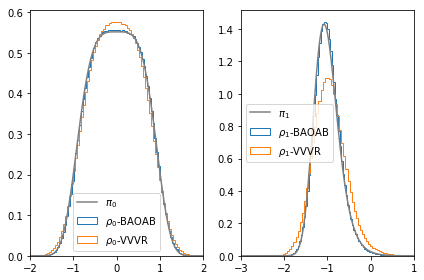

In [8]:
ax = plt.subplot(1,2,1)
# \lambda = 0
plt.plot(x_, q(x_, 0) / Z_0, color='grey', label=r'$\pi_0$')
plt.hist(baoab_rho_x_0, bins=100, histtype="step", label=r"$\rho_0$-BAOAB", normed=True);
plt.hist(vvvr_rho_x_0, bins=100, histtype="step", label=r"$\rho_0$-VVVR", normed=True);
plt.legend(loc='best')
plt.xlim(-2,2)

plt.subplot(1,2,2)
# \lambda = 1
plt.plot(x_, q(x_, 1) / Z_1, color='grey', label=r'$\pi_1$')
plt.hist(baoab_rho_x_1, bins=100, histtype="step", label=r"$\rho_1$-BAOAB", normed=True);
plt.hist(vvvr_rho_x_1, bins=100, histtype="step", label=r"$\rho_1$-VVVR", normed=True);
plt.xlim(-3,1)
plt.legend(loc='best')
plt.tight_layout()

# 7. Collect work measurements for switching from $\lambda=0$ to $\lambda=1$ (and reverse)

In [9]:

n_protocol_samples = 100000

def simulate_protocol(initial_x_ensemble, initial_v_ensemble, protocol, integrator):
    i = np.random.randint(len(initial_x_ensemble))
    args = (initial_x_ensemble[i], initial_v_ensemble[i], protocol)
    if integrator == "VVVR":
        return simulate_vvvr(*args)
    elif integrator == "BAOAB":
        return simulate_baoab(*args)
    elif integrator == "BBK":
        return simulate_bbk(*args)

Result = namedtuple("Result", ["forward_raw", "reverse_raw", "forward_corrected", "reverse_corrected",
                               "forward_proposal", "reverse_proposal"])


def collect_samples(ensemble="rho", protocol_length=100, integrator="VVVR"):
    # collect forward and reverse work values
    forward, reverse = np.zeros(n_protocol_samples), np.zeros(n_protocol_samples)
    forward_proposal, reverse_proposal = np.zeros(n_protocol_samples), np.zeros(n_protocol_samples)
    forward_corrected, reverse_corrected = np.zeros(n_protocol_samples), np.zeros(n_protocol_samples)
    
    forward_protocol = np.linspace(0, 1, protocol_length)
    reverse_protocol = np.linspace(1, 0, protocol_length)
    
    
    if integrator == "VVVR":
        rho_x_0, rho_v_0, rho_x_1, rho_v_1 = vvvr_rho_x_0, vvvr_rho_v_0, vvvr_rho_x_1, vvvr_rho_v_1
    elif integrator == "BAOAB":
        rho_x_0, rho_v_0, rho_x_1, rho_v_1 = baoab_rho_x_0, baoab_rho_v_0, baoab_rho_x_1, baoab_rho_v_1
                    
    if ensemble == "rho":
        x_0, v_0 = rho_x_0, rho_v_0
        x_1, v_1 = rho_x_1, rho_v_1
    elif ensemble == "pi":
        x_0, v_0 = pi_x_0, pi_v_0
        x_1, v_1 = pi_x_1, pi_v_1

    for i in tqdm(range(n_protocol_samples)):
        xs_forward, _, W_shads_F, W_prots_F = simulate_protocol(x_0, v_0, forward_protocol, integrator)
        xs_reverse, _, W_shads_R, W_prots_R = simulate_protocol(x_1, v_1, reverse_protocol, integrator)

        forward[i]  = np.sum(W_prots_F)
        reverse[i] = np.sum(W_prots_R)
        
        forward_proposal[i] = xs_forward[-1]
        reverse_proposal[i] = xs_reverse[-1]

        forward_corrected[i]  = np.sum(W_prots_F) + np.sum(W_shads_F)
        reverse_corrected[i] = np.sum(W_prots_R) + np.sum(W_shads_R)
    
    result = Result(forward, reverse, forward_corrected, reverse_corrected, forward_proposal, reverse_proposal)
    return result

In [10]:
from tqdm import tqdm
#protocol_lengths = [2, 10, 100, 250, 500, 1000, 2500, 5000, 10000]
protocol_lengths = [10, 100, 1000, 10000] # for prototyping / getting the figure concept, just look at a few protocol lengths...

results = dict()
for integrator in ['VVVR', 'BAOAB']:
    rho_results, pi_results = [], []
    for protocol_length in protocol_lengths:
        rho_results.append(collect_samples("rho", protocol_length, integrator=integrator))
        pi_results.append(collect_samples("pi", protocol_length, integrator=integrator))
    results[integrator] = {'rho_results': rho_results, 'pi_results': pi_results}

100%|██████████| 100000/100000 [02:15<00:00, 737.35it/s]


# 8. Inspect the joint distributions of $w_\text{shad}$ and $w_\text{protocol}$

In [11]:
len(protocol_lengths)

4

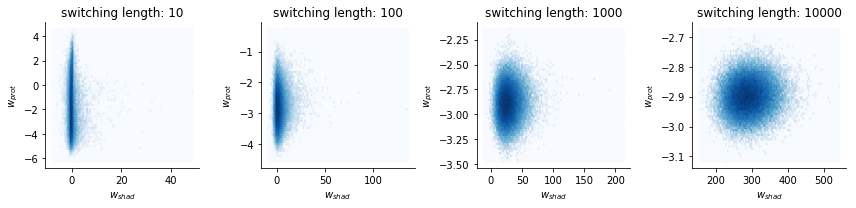

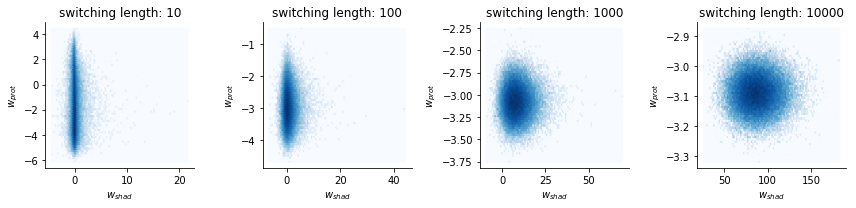

In [12]:
for integrator in results:
    rho_results, pi_results = results[integrator]['rho_results'], results[integrator]['pi_results']

    plt.figure(figsize=(3*len(protocol_lengths), 3))
    for i in range(len(protocol_lengths)):
        ax = plt.subplot(1,len(protocol_lengths),i + 1)
        w_prot = rho_results[i].forward_raw
        w_shad = rho_results[i].forward_corrected - rho_results[i].forward_raw
        plt.hexbin(w_shad, w_prot, bins='log', cmap='Blues')
        plt.xlabel(r'$w_{shad}$')
        plt.ylabel(r'$w_{prot}$')
        plt.title('switching length: {}'.format(protocol_lengths[i]))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig('w_prot-vs-w_shads-{}.jpg'.format(integrator), dpi=300)

## Is there a good way to illustrate the forward and reverse work distributions on the same axes?

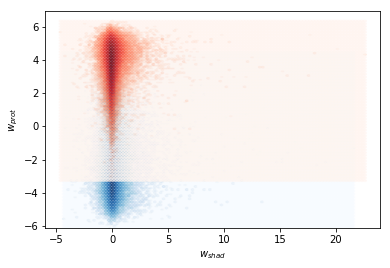

In [13]:
i = 0
w_prot = rho_results[i].forward_raw
w_shad = rho_results[i].forward_corrected - rho_results[i].forward_raw
plt.hexbin(w_shad, w_prot,
           bins='log', cmap='Blues', alpha=0.5)
w_prot = rho_results[i].reverse_raw
w_shad = rho_results[i].reverse_corrected - rho_results[i].reverse_raw
plt.hexbin(w_shad, w_prot,
           bins='log', cmap='Reds', alpha=0.5)
plt.xlabel(r'$w_{shad}$')
plt.ylabel(r'$w_{prot}$')

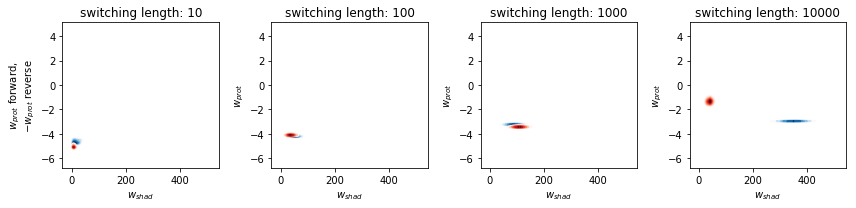

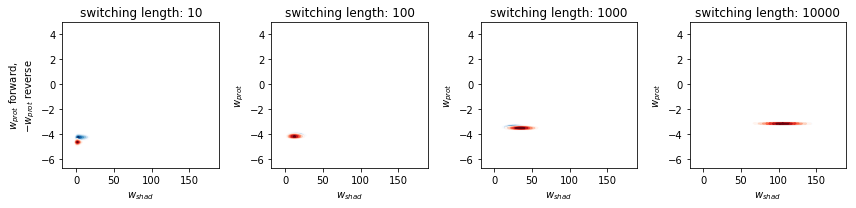

In [44]:
for integrator in results:
    rho_results, pi_results = results[integrator]['rho_results'], results[integrator]['pi_results']
    ax = None
    plt.figure(figsize=(3*len(protocol_lengths),3))
    for i in range(len(protocol_lengths)):
        ax = plt.subplot(1,len(protocol_lengths), i + 1, sharex=ax, sharey=ax)
        w_prot = np.nan_to_num(rho_results[i].forward_raw)
        w_shad = np.nan_to_num(rho_results[i].forward_corrected - rho_results[i].forward_raw)
        
        counts, x, y = np.histogram2d(w_shad, w_prot, bins=50, normed=True)

        plt.contour(x[1:], y[1:], counts, cmap='Blues', label='forward')
        plt.xlabel(r'$w_{shad}$')
        plt.ylabel(r'$w_{prot}$')

        w_prot = np.nan_to_num(rho_results[i].reverse_raw)
        w_shad = np.nan_to_num(rho_results[i].reverse_corrected - rho_results[i].reverse_raw)
        counts, x, y = np.histogram2d(w_shad, -w_prot, bins=50, normed=True)

        plt.contour(x[1:], y[1:], counts, cmap='Reds', label='reverse')
        plt.xlabel(r'$w_{shad}$')
        if i == 0:
            plt.ylabel(r'$w_{prot}$ forward,' + "\n" + r'$-w_{prot}$ reverse')

        plt.title('switching length: {}'.format(protocol_lengths[i]))
    plt.tight_layout()
    plt.savefig('forward-and-reverse-{}.jpg'.format(integrator), dpi=300, bbox_inches='tight')

# 9. Inspect the distributions of protocol work and shadow work separately

In [15]:
import seaborn.apionly as sns
w_prot_colors = sns.color_palette('Oranges', len(protocol_lengths))
w_shad_colors = sns.color_palette('Blues', len(protocol_lengths))

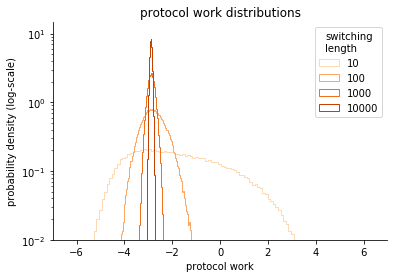

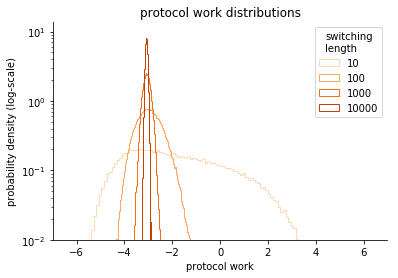

In [16]:
for integrator in results:
    rho_results, pi_results = results[integrator]['rho_results'], results[integrator]['pi_results']
    
    plt.figure(figsize=(6,4))
    ax = plt.subplot(111)

    for i in range(len(protocol_lengths)):
        w_prot = rho_results[i].forward_raw
        plt.hist(w_prot[np.isfinite(w_prot)], histtype='step', bins=100, normed=True, color=w_prot_colors[i], label=str(protocol_lengths[i]))
    plt.yscale('log')
    plt.legend(loc='best', title='switching\nlength')
    plt.ylim(1e-2,)
    plt.xlim(-7,7)
    plt.xlabel('protocol work')
    plt.ylabel('probability density (log-scale)')
    plt.title('protocol work distributions')



    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig('protocol-work-distributions-{}.jpg'.format(integrator), dpi=300)

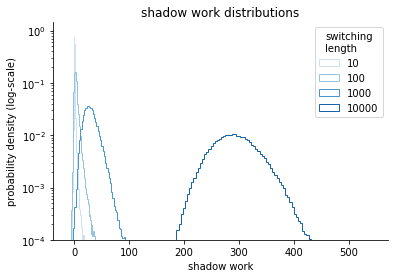

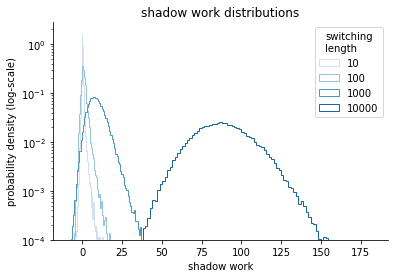

In [17]:
for integrator in results:
    rho_results, pi_results = results[integrator]['rho_results'], results[integrator]['pi_results']
    plt.figure(figsize=(6,4))
    ax = plt.subplot(111)

    for i in range(len(protocol_lengths)):
        w_shad = rho_results[i].forward_corrected - rho_results[i].forward_raw
        plt.hist(w_shad[np.isfinite(w_shad)], histtype='step', bins=100, normed=True, color=w_shad_colors[i], label=str(protocol_lengths[i]))
    plt.yscale('log')
    plt.legend(loc='best', title='switching\nlength')
    plt.ylim(1e-4,)
    #plt.xlim(-7,7)
    plt.xlabel('shadow work')
    plt.ylabel('probability density (log-scale)')
    plt.title('shadow work distributions')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig('shadow-work-distributions-{}.jpg'.format(integrator), dpi=300)

In [18]:
w_shad_color, w_prot_color = sns.color_palette()[:2]

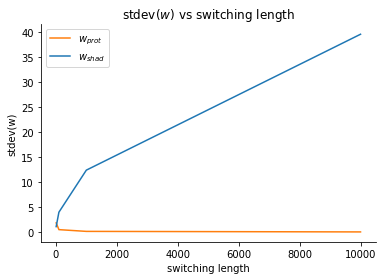

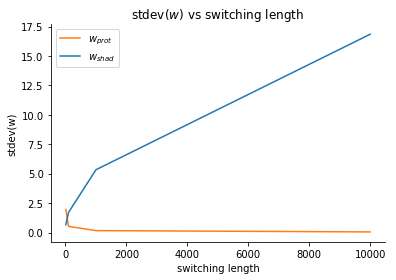

In [19]:
for integrator in results:
    rho_results, pi_results = results[integrator]['rho_results'], results[integrator]['pi_results']

    plt.figure(figsize=(6,4))
    ax = plt.subplot(1,1,1)

    w_prot_stdevs = np.zeros(len(protocol_lengths))
    w_shad_stdevs = np.zeros(len(protocol_lengths))

    w_prot_means = np.zeros(len(protocol_lengths))
    w_shad_means = np.zeros(len(protocol_lengths))

    for i in range(len(protocol_lengths)):
        w_prot = rho_results[i].forward_raw
        w_shad = rho_results[i].forward_corrected - rho_results[i].forward_raw



        w_prot_stdevs[i] = w_prot[np.isfinite(w_prot)].std()
        w_shad_stdevs[i] = w_shad[np.isfinite(w_shad)].std()

        w_prot_means[i] = w_prot[np.isfinite(w_prot)].mean()
        w_shad_means[i] = w_shad[np.isfinite(w_shad)].mean()

    plt.plot(protocol_lengths, w_prot_stdevs, label=r'$w_{prot}$', color=w_prot_color)
    plt.plot(protocol_lengths, w_shad_stdevs, label=r'$w_{shad}$', color=w_shad_color)

    plt.xlabel('switching length')
    plt.ylabel('stdev(w)')
    plt.legend(loc='best')
    plt.title(r'stdev($w$) vs switching length')


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig('stdev(w)-vs-switching-length-linear-scale-{}.jpg'.format(integrator), dpi=300)

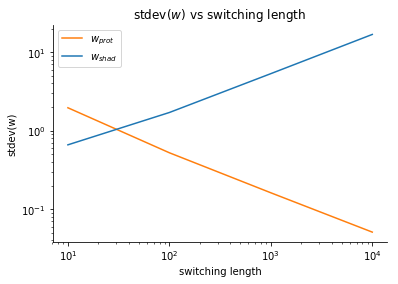

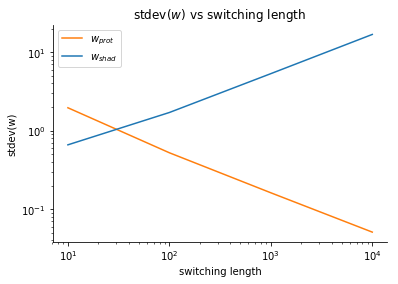

In [20]:
for integrator in results:
    rho_results, pi_results = results[integrator]['rho_results'], results[integrator]['pi_results']
    plt.figure(figsize=(6,4))
    ax = plt.subplot(1,1,1)

    plt.plot(protocol_lengths, w_prot_stdevs, label=r'$w_{prot}$', color=w_prot_color)
    plt.plot(protocol_lengths, w_shad_stdevs, label=r'$w_{shad}$', color=w_shad_color)

    plt.xscale('log')

    plt.yscale('log')
    #plt.yticks([0,5,10,15])
    plt.xlabel('switching length')
    plt.ylabel('stdev(w)')
    plt.legend(loc='best')
    plt.title(r'stdev($w$) vs switching length')


    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.savefig('stdev(w)-vs-switching-length-log-scale-{}.jpg'.format(integrator), dpi=300)

# 10. Compute $\Delta F$ estimates from BAR, forward EXP, and reverse EXP using corrected vs. uncorrected work

In [25]:
def bootstrap_sample(samples, n_bootstrap_samples=100):
    """Draw n_bootstrap_samples with replacement from samples."""
    indices = np.random.randint(0, len(samples), n_bootstrap_samples)
    return samples[indices]

In [39]:
# plot estimate rmse as function of n_samples

n_sample_list = np.array(np.logspace(1, 5, 20), dtype=int)

def only_finite(array):
    return array[np.isfinite(array)]


estimators = {'BAR': lambda f, r: pymbar.bar.BAR(f, r, compute_uncertainty=False),
              'EXP_F': lambda f, r: pymbar.EXP(f, compute_uncertainty=False),
              'EXP_R': lambda f, r: pymbar.EXP(r, compute_uncertainty=False),
             }

def get_estimates(result, estimator='BAR', n_replicates=10):
    assert(estimator in estimators.keys())
    
    raw_estimates = np.zeros((n_replicates, len(n_sample_list)))
    corrected_estimates = np.zeros((n_replicates, len(n_sample_list)))
    f_boostrap, r_bootrap = None, None

    for i in tqdm(range(n_replicates)):
        for j, n_samples in enumerate(n_sample_list):

            # just protocol work
            if estimator in ['BAR', 'EXP_F']:
                f_bootstrap = bootstrap_sample(only_finite(result.forward_raw), n_samples)
            if estimator in ['BAR', 'EXP_R']:
                r_bootstrap = bootstrap_sample(only_finite(result.reverse_raw), n_samples)

            #raw_estimate, _ = pymbar.bar.BAR(f_bootstrap, r_bootstrap)
            raw_estimate = estimators[estimator](f_bootstrap, r_bootstrap)
            raw_estimates[i, j] = raw_estimate

            # protocol work + shadow work
            if estimator in ['BAR', 'EXP_F']:
                f_bootstrap = bootstrap_sample(only_finite(result.forward_corrected), n_samples)
            if estimator in ['BAR', 'EXP_R']:
                r_bootstrap = bootstrap_sample(only_finite(result.reverse_corrected), n_samples)

            #corrected_estimate, _ = pymbar.bar.BAR(f_bootstrap, r_bootstrap)
            corrected_estimate = estimators[estimator](f_bootstrap, r_bootstrap)
            corrected_estimates[i, j] = corrected_estimate
    
    return raw_estimates, corrected_estimates
n_sample_list

array([    10,     16,     26,     42,     69,    112,    183,    297,
          483,    784,   1274,   2069,   3359,   5455,   8858,  14384,
        23357,  37926,  61584, 100000])

# 11. Check the free energy difference you would estimate from MBAR but with samples from $\rho_0$, $\rho_1$ instead of $\pi_0$, $\pi_1$

In [40]:
# todo

# 12. Decompose the error into bias vs variance

In [41]:
def plot_rmse(raw_estimates, corrected_estimates, ensemble="rho"):
    
    if ensemble == "rho":
        uncorrected_label = r"without shadow work ($\rho$)"
        corrected_label = r"with shadow work ($\rho$)"
    elif ensemble == "pi":
        uncorrected_label = r"without shadow work ($\pi$)"
        corrected_label = r"with shadow work ($\pi$)"

    plt.errorbar(n_sample_list,
                 np.sqrt(np.mean((raw_estimates - exact_free_energy_difference)**2, 0)),
                 np.std(np.abs(raw_estimates - exact_free_energy_difference), 0) / np.sqrt(len(raw_estimates)),
                 label=uncorrected_label)
    plt.errorbar(n_sample_list,
                 np.sqrt(np.mean((corrected_estimates - exact_free_energy_difference)**2, 0)),
                 np.std(np.abs(corrected_estimates - exact_free_energy_difference), 0) / np.sqrt(len(corrected_estimates)),
                 label=corrected_label)

    plt.hlines(0, min(n_sample_list), max(n_sample_list), linestyles='--')
    plt.ylabel("RMSE")
    plt.xlabel("# protocol samples")
    plt.legend(loc="best")
    plt.title("RMSE")

In [43]:
n_bootstrap = 100
estimates = dict()

estimator = 'EXP_F'
# TODO: loop over other estimators, later


for integrator in results:
    rho_results, pi_results = results[integrator]['rho_results'], results[integrator]['pi_results']
    rho_estimates, pi_estimates = [], []

    for i in range(len(protocol_lengths)):
        rho_estimates.append((get_estimates(rho_results[i], n_replicates=n_bootstrap)))
        pi_estimates.append((get_estimates(pi_results[i], n_replicates=n_bootstrap)))
    estimates[integrator] = {'rho_estimates': rho_estimates, 'pi_estimates': pi_estimates}


100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


In [51]:
def plot_standard_error_band(x, ys, color="blue", label="", linestyle='-'):
    mean = np.mean(ys, 0)
    stderr = np.std(ys, 0) / np.sqrt(len(ys))
    
    plt.plot(x, mean, color=color, linestyle=linestyle, label=label)
    plt.fill_between(x, mean - 1.96 * stderr, mean + 1.96 * stderr, color=color, alpha=0.2)
    
def plot_standard_deviation_band(x, ys, color="blue", label="", linestyle='-'):
    mean = np.mean(ys, 0)
    stdev = np.std(ys, 0)
    
    plt.plot(x, mean, color=color, linestyle=linestyle, label=label)
    plt.fill_between(x, mean -  1.96 * stdev, mean + 1.96 * stdev, color=color, alpha=0.2)

In [46]:
import seaborn.apionly as sns
colors = sns.color_palette("Paired")

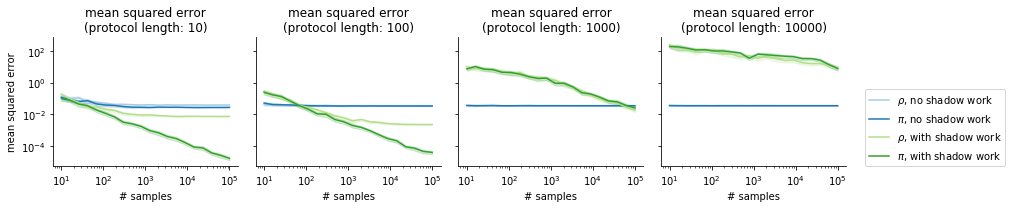

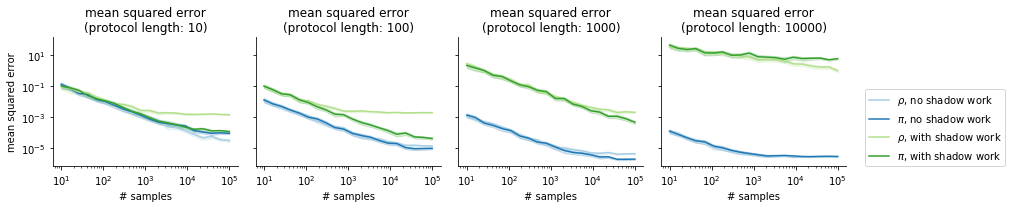

In [67]:
# plot the estimator bias, variance, at fixed protocol length

# rmse
def get_MSE(estimates):
    return ((estimates - exact_free_energy_difference)**2).mean(0)

for integrator in estimates:
    
    rho_estimates, pi_estimates = estimates[integrator]['rho_estimates'], estimates[integrator]['pi_estimates']
    plt.figure(figsize=(3 * len(protocol_lengths),3))


    ax = None
    for i in range(len(protocol_lengths)):
        ax = plt.subplot(1, len(protocol_lengths), i + 1, sharey=ax)
        raw_estimates_rho, corrected_estimates_rho = rho_estimates[i]
        raw_estimates_pi, corrected_estimates_pi = pi_estimates[i]

        labeled_estimates = [(raw_estimates_rho, r"$\rho$, no shadow work"),
                             (raw_estimates_pi, r"$\pi$, no shadow work"),
                             (corrected_estimates_rho, r"$\rho$, with shadow work"),
                             (corrected_estimates_pi, r"$\pi$, with shadow work")
                            ]


        for j, (estimate, label) in enumerate(labeled_estimates):

            mses = np.vstack([get_MSE(estimate[np.random.randint(0,len(estimate),len(estimate))]) for _ in range(100)])
            plot_standard_deviation_band(n_sample_list, mses, color=colors[j], label=label)
            #plt.plot(n_sample_list, get_MSE(estimate), label=label)

        #plt.hlines(exact_free_energy_difference, min(n_sample_list), max(n_sample_list))
        plt.yscale('log')
        plt.xscale('log')
        if i == len(protocol_lengths) - 1:
            plt.legend(loc=(1.1,0))
        plt.xlabel("# samples")
        if i == 0:
            plt.ylabel("mean squared error")
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.title("mean squared error\n(protocol length: {})".format(protocol_lengths[i]))
    plt.tight_layout()
    plt.savefig('mse-{}.jpg'.format(integrator), dpi=300, bbox_inches='tight')

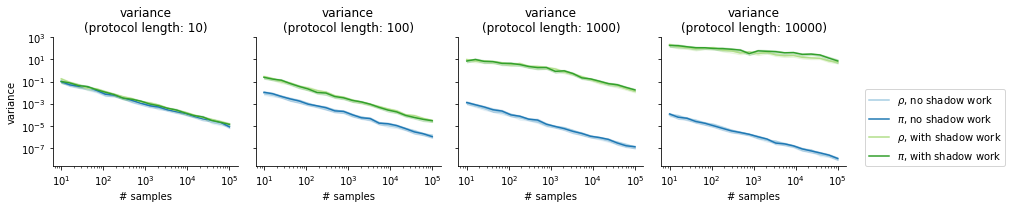

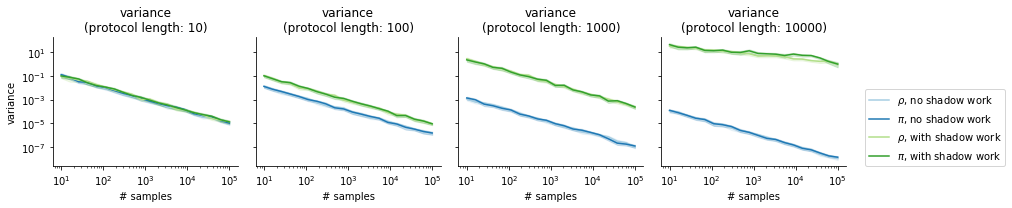

In [48]:
def get_variance(estimates):
    return np.std(estimates, 0)**2


for integrator in estimates:
    
    rho_estimates, pi_estimates = estimates[integrator]['rho_estimates'], estimates[integrator]['pi_estimates']
    plt.figure(figsize=(3 * len(protocol_lengths),3))
    ax = None

    for i in range(len(protocol_lengths)):
        ax = plt.subplot(1, len(protocol_lengths), i + 1, sharey=ax)
        raw_estimates_rho, corrected_estimates_rho = rho_estimates[i]
        raw_estimates_pi, corrected_estimates_pi = pi_estimates[i]

        labeled_estimates = [(raw_estimates_rho, r"$\rho$, no shadow work"),
                             (raw_estimates_pi, r"$\pi$, no shadow work"),
                             (corrected_estimates_rho, r"$\rho$, with shadow work"),
                             (corrected_estimates_pi, r"$\pi$, with shadow work")
                            ]

        for j, (estimate, label) in enumerate(labeled_estimates):

            variances = np.vstack([get_variance(estimate[np.random.randint(0,len(estimate),len(estimate))]) for _ in range(100)])
            plot_standard_deviation_band(n_sample_list, variances, color=colors[j], label=label)


        #plt.hlines(exact_free_energy_difference, min(n_sample_list), max(n_sample_list))
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel("# samples")


        if i == len(protocol_lengths) - 1:
            plt.legend(loc=(1.1,0))
        plt.xlabel("# samples")
        if i == 0:
            plt.ylabel("variance")
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.title("variance\n(protocol length: {})".format(protocol_lengths[i]))
    plt.tight_layout()
    plt.savefig('variance-{}.jpg'.format(integrator), dpi=300, bbox_inches='tight')

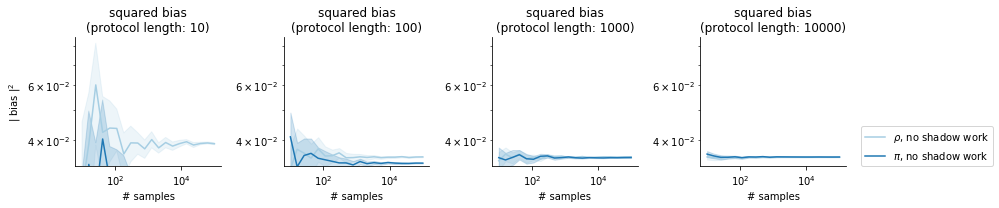

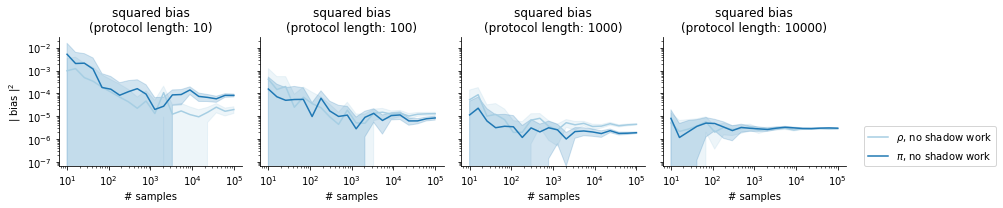

In [50]:
def get_bias(estimates):
    #return np.abs(np.mean(estimates - exact_free_energy_difference, 0))**2
    return np.abs(np.mean(estimates, 0) - exact_free_energy_difference)**2
    
    
for integrator in estimates:
    
    rho_estimates, pi_estimates = estimates[integrator]['rho_estimates'], estimates[integrator]['pi_estimates']
    plt.figure(figsize=(3 * len(protocol_lengths),3))
    ax = None

    for i in range(len(protocol_lengths)):
        ax = plt.subplot(1, len(protocol_lengths), i + 1, sharey=ax)
        raw_estimates_rho, corrected_estimates_rho = rho_estimates[i]
        raw_estimates_pi, corrected_estimates_pi = pi_estimates[i]

        labeled_estimates = [(raw_estimates_rho, r"$\rho$, no shadow work"),
                             (raw_estimates_pi, r"$\pi$, no shadow work"),
                             #(corrected_estimates_rho, r"$\rho$, with shadow work"),
                             #(corrected_estimates_pi, r"$\pi$, with shadow work")
                            ]
        #for estimate, label in labeled_estimates:
        #    plt.plot(n_sample_list, get_bias(estimate), label=label)


        for j, (estimate, label) in enumerate(labeled_estimates):

            biases = np.vstack([get_bias(estimate[np.random.randint(0,len(estimate),len(estimate))]) for _ in range(100)])
            assert(np.alltrue(np.isfinite(biases)))
            plot_standard_deviation_band(n_sample_list, biases, color=colors[j], label=label)

        #plt.hlines(exact_free_energy_difference, min(n_sample_list), max(n_sample_list))
        plt.yscale('log')
        plt.xscale('log')
        plt.xlabel("# samples")


        if i == len(protocol_lengths) - 1:
            plt.legend(loc=(1.1,0))
        plt.xlabel("# samples")
        if i == 0:
            plt.ylabel(r"$\|$ bias $\|^2$")
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.title("squared bias\n(protocol length: {})".format(protocol_lengths[i]))
    plt.tight_layout()
    plt.savefig('bias-{}.jpg'.format(integrator), dpi=300, bbox_inches='tight')

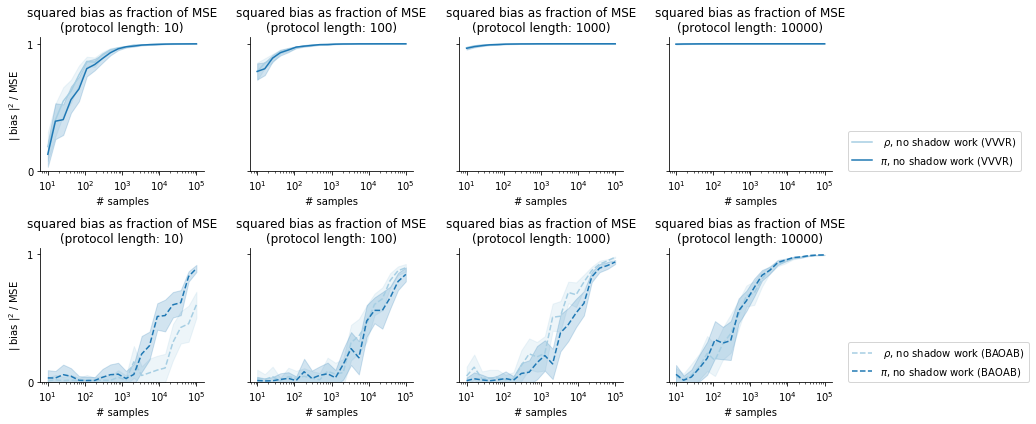

In [69]:
# MSE = Var + Bias^2
# Assess by Bias^2 / MSE


# TODO: modify this plot to: 
# - [x] Be on a linear y-scale instead of a log-scale
# - [ ] Omit the unbiased examples (including shadow work)
# - [ ] Include two integrators on the same axes

def get_bias_contribution(estimates):
    return get_bias(estimates) / get_MSE(estimates)

def get_bias(estimates):
    #return np.abs(np.mean(estimates - exact_free_energy_difference, 0))**2
    return np.abs(np.mean(estimates, 0) - exact_free_energy_difference)**2
    
    
linestyles = {'BAOAB': '--', 'VVVR': '-'}
plt.figure(figsize=(3 * len(protocol_lengths),3 * 2))
ax = None
plot = 1
for integrator in estimates:
    
    rho_estimates, pi_estimates = estimates[integrator]['rho_estimates'], estimates[integrator]['pi_estimates']

    for i in range(len(protocol_lengths)):
        ax = plt.subplot(2, len(protocol_lengths), plot, sharey=ax)
        plot += 1
        raw_estimates_rho, corrected_estimates_rho = rho_estimates[i]
        raw_estimates_pi, corrected_estimates_pi = pi_estimates[i]

        labeled_estimates = [(raw_estimates_rho, r" $\rho$, no shadow work" + " ({})".format(integrator)),
                             (raw_estimates_pi, r"$\pi$, no shadow work" + " ({})".format(integrator)),
                             #(corrected_estimates_rho, r"$\rho$, with shadow work"),
                             #(corrected_estimates_pi, r"$\pi$, with shadow work")
                            ]
        #for estimate, label in labeled_estimates:
        #    plt.plot(n_sample_list, get_bias_contribution(estimate), label=label)

        for j, (estimate, label) in enumerate(labeled_estimates):

            bias_contributions = np.vstack([get_bias_contribution(estimate[np.random.randint(0,len(estimate),len(estimate))]) for _ in range(100)])

            plot_standard_deviation_band(n_sample_list, bias_contributions, color=colors[j], label=label, linestyle=linestyles[integrator])

        #plt.hlines(exact_free_energy_difference, min(n_sample_list), max(n_sample_list))
        plt.xscale('log')
        plt.xlabel("# samples")
        
        plt.ylim(0,1.05)
        plt.yticks([0,1])


        if i == len(protocol_lengths) - 1:
            plt.legend(loc=(1.1,0))
        plt.xlabel("# samples")
        if i == 0:
            plt.ylabel(r"$\|$ bias $\|^2$ / MSE")
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.title("squared bias as fraction of MSE\n(protocol length: {})".format(protocol_lengths[i]))
    plt.tight_layout()
plt.savefig('bias_contributions.jpg'.format(integrator), dpi=300, bbox_inches='tight')

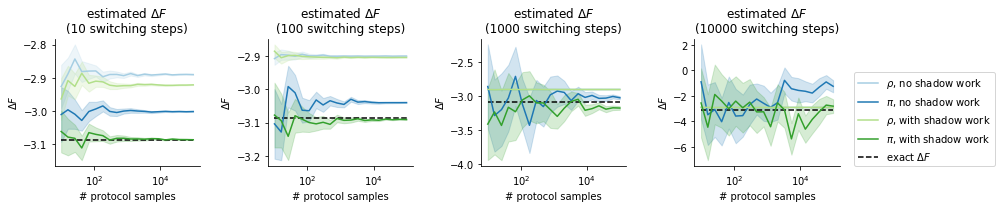

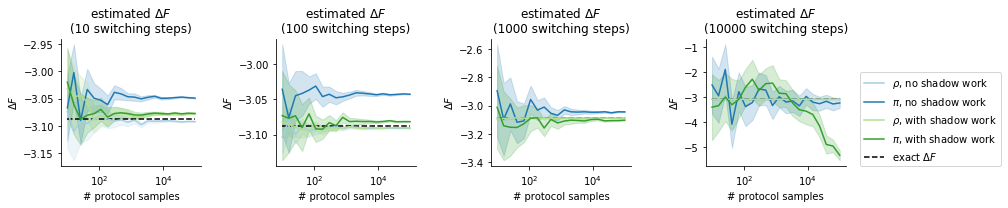

In [57]:
for integrator in estimates:
    
    rho_estimates, pi_estimates = estimates[integrator]['rho_estimates'], estimates[integrator]['pi_estimates']
    plt.figure(figsize=(3 * len(protocol_lengths),3))
    ax = None

    for i in range(len(protocol_lengths)):
        ax = plt.subplot(1, len(protocol_lengths), i + 1)

        plt.hlines(exact_free_energy_difference, min(n_sample_list), max(n_sample_list), linestyle="--", label=r"exact $\Delta F$")


        labeled_estimates = [(rho_estimates[i][0], r"$\rho$, no shadow work"),
                             (rho_estimates[i][1], r"$\pi$, no shadow work"),
                             (pi_estimates[i][0], r"$\rho$, with shadow work"),
                             (pi_estimates[i][1], r"$\pi$, with shadow work")
                            ]
        for j, (estimate, label) in enumerate(labeled_estimates):
            plot_standard_error_band(n_sample_list, estimate, color=colors[j], label=label)
        plt.xscale('log')
        if i == len(protocol_lengths) - 1:
            plt.legend(loc=(1.1,0))
        plt.xlabel("# samples")
        if i == 0:
            plt.ylabel(r"$\|$ bias $\|^2$ / MSE")
        plt.xlabel("# protocol samples")
        plt.ylabel(r"$\Delta F$")
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        plt.title(r"estimated $\Delta F$" + "\n({} switching steps)".format(protocol_lengths[i]))
        #plt.yticks([-2.5,-3,-3.5])
    plt.tight_layout()
    plt.savefig('free_energy_estimates-{}.jpg'.format(integrator), dpi=300, bbox_inches='tight')

In [102]:
from statsmodels.nonparametric.kde import KDEUnivariate

In [103]:
def figure_5(forward_work, reverse_work):
    # flip sign of reverse work
    reverse_work = - reverse_work
    
    # set x-limits for plotting
    x_min = min(min(forward_work), min(reverse_work))
    x_max = max(max(forward_work), max(reverse_work))
    
    x_space = np.linspace(x_min, x_max, 1000)
    
    # get kernel density estimates of the forward and reverse work distributions
    kde_f = KDEUnivariate(forward_work)
    kde_f.fit()
    p_f = kde_f.evaluate(x_space)
    
    kde_r = KDEUnivariate(reverse_work)
    kde_r.fit()
    p_r = kde_r.evaluate(x_space)
    
    
    # plot
    trimming_fraction = 0.2
    trimming = int(trimming_fraction * len(x_space))
    trimmed = slice(trimming, -trimming)
    
    plt.subplot(1, 2, 1)
    plt.plot(x_space[trimmed], p_f[trimmed], label="$w_f$")
    plt.plot(x_space[trimmed], p_r[trimmed], label="$-w_r$")
    plt.yscale('log')
    plt.ylabel("KDE")
    plt.xlabel("work")
    
    
    
    plt.subplot(1, 2, 2)
    x, y = x_space[trimmed], np.exp(np.log(p_f) - np.log(p_r))[trimmed]
    plt.plot(x, y, '.')
    plt.yscale('log')
    plt.xlabel(r"x")
    plt.ylabel("$p(w_f) / p(-w_r)$")
    plt.xlabel("work")
    plt.tight_layout()
    
    plt.vlines(exact_free_energy_difference, min(y), max(y))
    return x_space, p_f, p_r

# 13. Replicate validation figure

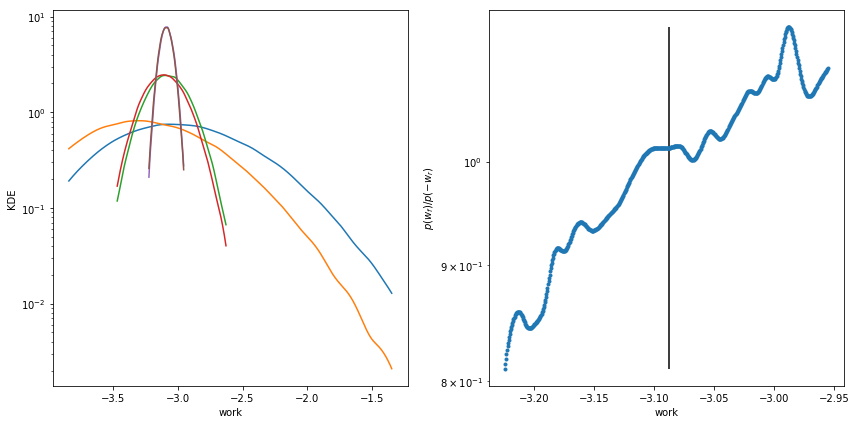

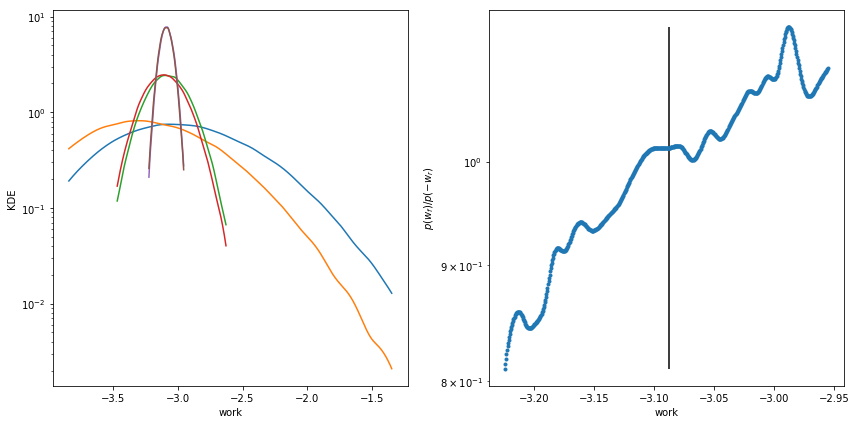

In [105]:
for integrator in estimates:
    
    rho_estimates, pi_estimates = estimates[integrator]['rho_estimates'], estimates[integrator]['pi_estimates']
    plt.figure(figsize=(3 * len(rho_results),3 * 2))
    figure_5_data = []
    for i in range(len(rho_results)):
        plt.subplot(1, len(rho_results), i + 1)
        plt.title("switching length: {} steps".format(protocol_lengths[i]))
        figure_5_data.append(tuple(figure_5(rho_results[i].forward_raw, rho_results[i].reverse_raw)))
    plt.tight_layout()
    plt.savefig('fig5-test-{}.jpg'.format(integrator), dpi=300, bbox_inches='tight')

# 14. Decision diagram
Show a matrix of which scheme gives lowest MSE as a function of n_samples vs. switching length:

In [58]:
rho_estimates = estimates['BAOAB']['rho_estimates']

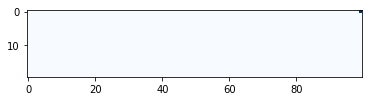

In [59]:
baoab_decision_matrix = get_MSE(rho_estimates)
decision_matrix = np.argmin(baoab_decision_matrix, axis=0)
plt.imshow(decision_matrix.T, cmap="Blues")

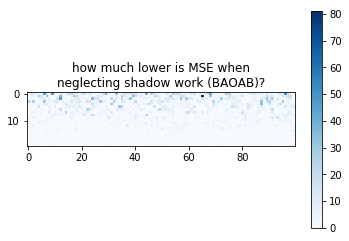

In [60]:
baoab_decision_matrix = get_MSE(rho_estimates)

plt.imshow((baoab_decision_matrix[1] - baoab_decision_matrix[0]).T, cmap="Blues")
plt.colorbar()
plt.title('how much lower is MSE when\nneglecting shadow work (BAOAB)?')

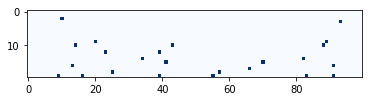

In [61]:
rho_estimates = estimates['VVVR']['rho_estimates']
vvvr_decision_matrix = get_MSE(rho_estimates)
decision_matrix = np.argmin(vvvr_decision_matrix, axis=0)
plt.imshow(decision_matrix.T, cmap="Blues")

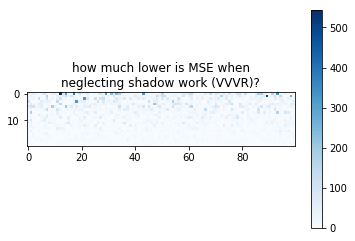

In [62]:
plt.imshow((vvvr_decision_matrix[1] - vvvr_decision_matrix[0]).T, cmap="Blues")
plt.colorbar()
plt.title('how much lower is MSE when\nneglecting shadow work (VVVR)?')

In [63]:
baoab_decision_tensor = np.vstack([get_MSE(rho_estimates), get_MSE(pi_estimates)])
decision_matrix = np.argmin(baoab_decision_tensor, axis=0)

In [64]:
set(decision_matrix.flatten())

{0, 1, 2}

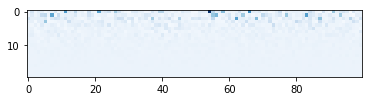

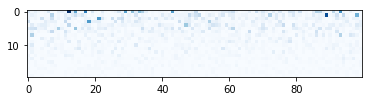

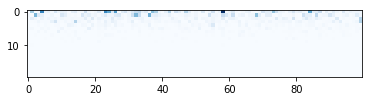

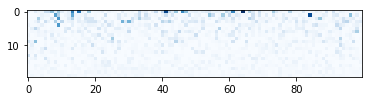

In [65]:
for i in range(len(baoab_decision_tensor)):
    plt.figure()
    plt.imshow(baoab_decision_tensor[i].T, cmap="Blues")

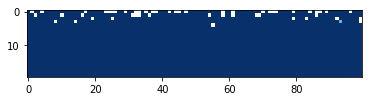

In [66]:
plt.imshow(decision_matrix.T, cmap="Blues")